# Outliers Demonstration
Julian Hsu

Use simulated data to understand the implication of different types of outliers: (1) explainable outliers, (2) unexplainable outliers, and (3) outliers driven by skewed X distributions.

First we will understand the distribution of biases of having outliers that are explainable due to observables versus not. 

Then we will see how different strategies ssuch as winsorization can help.

In [8]:
import pandas as pd
import numpy as np
import os as os 

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.conditional_models import ConditionalLogit

from IPython.display import display    


import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error


In [9]:
import stnomics as st

In [10]:
## Write a function to write simulated data that has a skew in outcomes explainable byu observed features
def generate_data_skewed(te=100, skew_var=1, X_random = 0.05):
    N = 1000
    x1 = np.random.normal(0,skew_var, N)
    x2 = np.random.normal(0,skew_var, N)

    ## For a random X%, generate skewed outliers    
    random10 = int( N * X_random )    
    x1[0:random10] = np.random.uniform( np.percentile(x1,0.95),np.percentile(x1,0.95)*1.75, random10 )
    x2[0:random10] = np.random.uniform( np.percentile(x2,0.95),np.percentile(x2,0.95)*1.75, random10 )
    
    treatment_latent = 10*(x2-0.5)**2 + 10*x1
    m,s = np.average(treatment_latent), np.std(treatment_latent)
    treatment_latent = (treatment_latent - m) / s
    
    random_t = np.random.normal(0,1,N)
    
    treatment_latent += random_t
    
    treatment = np.array( np.exp(treatment_latent) / (1+ np.exp(treatment_latent)) > np.random.uniform(0,1,N) ).astype(np.int32)

    treatment[0:random10] = np.random.choice(2, random10)
    
    Y = 100 +1.5*x1 + 6*x2 + np.random.normal(0,1, N)

    GT = te
    Y += GT*(treatment==1) 
        
    df_est = pd.DataFrame({'x1':x1, 'x2':x2,'treatment':treatment, 'Y':Y, 'GT':GT} )
    return df_est

In [11]:
## Write a function to write simulated data that has a skew in outcomes explainable by observed features
## where the distribution of X is more smooth like lognormal
def generate_data_X_skewed(te=100, skew_var=1, X_random = 0):
    N = 1000
    x1 = np.random.lognormal(0,skew_var, N)
    x2 = np.random.lognormal(0,skew_var, N)

    treatment_latent = 10*(x2-0.5)**2 + 10*x1
    m,s = np.average(treatment_latent), np.std(treatment_latent)
    treatment_latent = (treatment_latent - m) / s
    
    random_t = np.random.normal(0,1,N)
    
    treatment_latent += random_t
    
    treatment = np.array( np.exp(treatment_latent) / (1+ np.exp(treatment_latent)) > np.random.uniform(0,1,N) ).astype(np.int32)
    
    Y = 100 +1.5*x1 + 6*x2 + np.random.normal(0,1, N)

    GT = te
    Y += GT*(treatment==1) 
        
    df_est = pd.DataFrame({'x1':x1, 'x2':x2,'treatment':treatment, 'Y':Y, 'GT':GT} )
    return df_est

In [12]:
## Now write a function that generates outliers outcomes based on random errors
def generate_data(te=100,skew_var=1):
    N = 1000
    x1 = np.random.normal(0,skew_var, N)
    x2 = np.random.normal(0,skew_var, N)

    treatment_latent = 10*(x2-0.5)**2 + 10*x1
    m,s = np.average(treatment_latent), np.std(treatment_latent)
    treatment_latent = (treatment_latent - m) / s
    
    random_t = np.random.normal(0,1,N)
    
    treatment_latent += random_t
    
    treatment = np.array( np.exp(treatment_latent) / (1+ np.exp(treatment_latent)) > np.random.uniform(0,1,N) ).astype(np.int32)

    Y = 100 +1.5*x1 + 6*x2+ np.random.normal(0,1, N)

    GT = te
    Y += GT*(treatment==1) 
    
    df_est = pd.DataFrame({'x1':x1, 'x2':x2,'treatment':treatment, 'Y':Y, 'TError':random_t, 'GT':GT} )
   
    return df_est

def generate_data_skewed_random(te=100, skew_var=1, X_random = 0.05):
    data_here= generate_data(te=te, skew_var = skew_var)
    ## For a random X of the sample, increase the outcome by a random number
    random10 = int( len(df) * X_random )
    x = np.random.uniform( np.percentile(data_here['Y'],0.95),
                                                  np.percentile(data_here['Y'],0.95)*1.5, random10 )
    data_here.loc[   (data_here.index < random10), 'Y'] += x
    return data_here

## Outliers in $X_i$ and $Y_i$


In [13]:
feature_list = ['x1','x2']
outcome_name = 'Y'
treatment_name = 'treatment'
split_name= 'splits'
n_data_splits = 4
aux_dict = {'lower':0, 'upper':1}
TrueEstimate = 50


In [14]:
## Outlier value in X resulting in an outlier value in Y
df = generate_data_skewed(te=TrueEstimate, skew_var=3, X_random=0.05)
display(df[['Y','x1','x2']].describe(percentiles=np.arange(0.90,1,0.025))  )

## Outlier value in Y due to random error
df = generate_data_skewed_random(te=TrueEstimate, skew_var=3, X_random = 0.05)
display(df[['Y','x1','x2']].describe(percentiles=np.arange(0.90,1,0.025))  )


## Outlier value in Y due to outlier values in X, but X is smoothly distributed
df = generate_data_X_skewed(te=TrueEstimate, skew_var=1, X_random = 0.05)
display(df[['Y','x1','x2']].describe(percentiles=np.arange(0.90,1,0.025))  )


,Y,x1,x2
count,1000.000000,1000.000000,1000.000000
mean,118.905047,-0.412245,-0.574673
std,34.285473,3.552743,3.556616
min,15.504708,-11.725080,-11.673457
50%,114.071595,-0.117418,-0.290468
90%,165.654610,3.890472,3.611781
92.5%,171.444547,4.328245,4.107249
95%,175.235554,4.943233,4.700996
97.5%,183.229190,5.970347,5.734192
max,216.029076,9.038891,9.762146


,Y,x1,x2
count,1000.000000,1000.000000,1000.000000
mean,129.782683,-0.027206,0.173705
std,35.983164,2.981953,2.949752
min,60.356561,-8.102545,-14.044491
50%,124.383436,-0.142679,0.153517
90%,176.098348,3.762211,3.830803
92.5%,182.614046,4.140313,4.413410
95%,191.374608,4.772793,4.895554
97.5%,210.458464,5.658731,5.948799
max,264.134121,9.413243,10.553113


,Y,x1,x2
count,1000.000000,1000.000000,1000.000000
mean,137.134221,1.702521,1.566537
std,29.136549,2.278931,1.764037
min,100.102597,0.027711,0.041287
50%,150.620058,1.001394,0.966309
90%,171.593073,3.685979,3.606536
92.5%,173.955605,4.310969,4.005118
95%,179.576210,5.345388,4.501210
97.5%,186.896685,8.022847,5.971959
max,249.114419,25.067946,16.044091


In [15]:
## Do this over many repetitions
te_list_A = []
se_list_A = []

te_list_B = []
se_list_B = []

te_list_C = []
se_list_C = []

sim_number = 100
for r in range(sim_number):
    ## Estimate with explainable outliers
    df = generate_data_skewed(te=TrueEstimate, skew_var=5, X_random=0.05)

    a = st.ate.dml.dml_plm(df, 
                split_name, feature_list, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)
    te_list_A.append(a['ATE TE'])
    se_list_A.append(a['ATE SE'])
    
    ## Estimate with un-explainable outliers
    df = generate_data_skewed_random(te=TrueEstimate, skew_var=5, X_random=0.05)

    a = st.ate.dml.dml_plm(df, 
                split_name, feature_list, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)
    te_list_B.append(a['ATE TE'])
    se_list_B.append(a['ATE SE'])    
    
    ## Estimate with explainable X values
    df = generate_data_X_skewed(te=TrueEstimate, skew_var=1, X_random = 0.05)
    a = st.ate.dml.dml_plm(df, 
                split_name, feature_list, outcome_name, treatment_name,
                RandomForestRegressor(n_estimators=200, random_state=27),
                RandomForestClassifier(n_estimators=200, random_state=27),
               n_data_splits,
               aux_dict)
    te_list_C.append(a['ATE TE'])
    se_list_C.append(a['ATE SE'])    




In [18]:

te_list_A = np.array(te_list_A)
se_list_A = np.array(se_list_A)

te_list_B = np.array(te_list_B)
se_list_B = np.array(se_list_B)

te_list_C = np.array(te_list_C)
se_list_C = np.array(se_list_C)

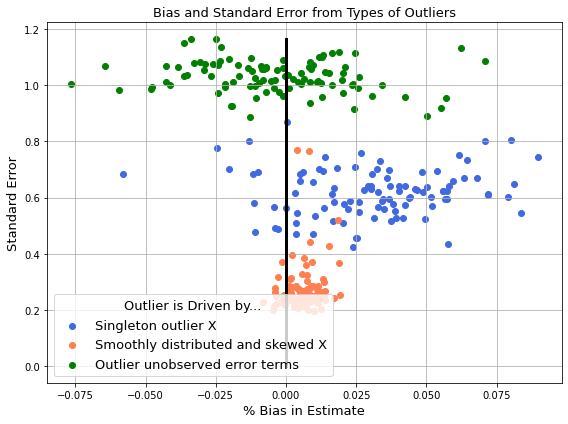

In [64]:
from matplotlib.ticker import AutoLocator

ft=13
fig,ax = plt.subplots(ncols=1, nrows=1, figsize=(8,6), sharex=True)
ax.scatter( x=(te_list_A-TrueEstimate)/TrueEstimate, 
              y= se_list_A, color='royalblue',
             label='Singleton outlier X')
ax.scatter( x=(te_list_C-TrueEstimate)/TrueEstimate, 
              y= se_list_C, color='coral',
             label='Smoothly distributed and skewed X')
ax.scatter( x=(te_list_B-TrueEstimate)/TrueEstimate, 
              y= se_list_B, color='green',
             label='Outlier unobserved error terms')

ax.set_xlabel('% Bias in Estimate', fontsize=ft)
# ax.set_xticklabels(labels=np.arange(-2,2), fontsize=ft)
ax.set_ylabel('Standard Error', fontsize=ft)
# ax.set_yticklabels(labels=np.arange(-2,2), fontsize=ft)
ax.plot( [0 ,0], 
           [0,np.max(np.concatenate( [se_list_A,se_list_B,se_list_C]))], color='black', linewidth=3)
ax.grid()
ax.legend(title='Outlier is Driven by...', loc='lower left', title_fontsize=ft, fontsize=ft)
ax.set_title('Bias and Standard Error from Types of Outliers',  fontsize=ft)
fig.set_facecolor('white')
plt.tight_layout()
plt.show()
